In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/modma-dataset/audio_lanzhou_2015/audio_lanzhou_2015/MODMA dataset-a Multi-modal Open Dataset for Mental-disorder Analysis.pdf
/kaggle/input/modma-dataset/audio_lanzhou_2015/audio_lanzhou_2015/subjects_information_audio_lanzhou_2015.xlsx
/kaggle/input/modma-dataset/audio_lanzhou_2015/audio_lanzhou_2015/A Novel Decision Tree for Depression Recognition in Speech.pdf
/kaggle/input/modma-dataset/audio_lanzhou_2015/audio_lanzhou_2015/02020008/17.wav
/kaggle/input/modma-dataset/audio_lanzhou_2015/audio_lanzhou_2015/02020008/10.wav
/kaggle/input/modma-dataset/audio_lanzhou_2015/audio_lanzhou_2015/02020008/14.wav
/kaggle/input/modma-dataset/audio_lanzhou_2015/audio_lanzhou_2015/02020008/02.wav
/kaggle/input/modma-dataset/audio_lanzhou_2015/audio_lanzhou_2015/02020008/03.wav
/kaggle/input/modma-dataset/audio_lanzhou_2015/audio_lanzhou_2015/02020008/05.wav
/kaggle/input/modma-dataset/audio_lanzhou_2015/audio_lanzhou_2015/02020008/19.wav
/kaggle/input/modma-dataset/audio_lanzhou_2015

In [2]:
import pandas as pd

# Define the path to the Excel file
excel_file_path = '/kaggle/input/modma-dataset/EEG_128channels_resting_lanzhou_2015/EEG_128channels_resting_lanzhou_2015/subjects_information_EEG_128channels_resting_lanzhou_2015.xlsx'

# Read the Excel file into a pandas DataFrame
subject_info = pd.read_excel(excel_file_path, sheet_name='Sheet1')
print(subject_info.head())

   subject id type  age gender  education（years）  PHQ-9  CTQ-SF  LES  SSRS  \
0     2010002  MDD   18      F                12     23      77 -143    31   
1     2010004  MDD   25      F                19     12      53  -44    38   
2     2010005  MDD   20      M                16     19      49   -3    28   
3     2010006  MDD   42      M                16     16      59  -30    40   
4     2010008  MDD   42      M                12     17      66  -71    44   

   GAD-7  PSQI  Unnamed: 11                              Unnamed: 12  
0     18    12          NaN                             abbreviation  
1     13    11          NaN          MDD = Major Depressive Disorder  
2     11     5          NaN                     HC = Healthy Control  
3     12     9          NaN     PHQ-9 = Patient Health Questionnaire  
4     18    13          NaN  CTQ-SF = Childhood Trauma Questionnaire  


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [1]:
import os
import re
import mne
import scipy.io as sio
import numpy as np
import pandas as pd
from mne.preprocessing import ICA

# ------------------------------
# 1️⃣ Load MODMA EEG dataset
# ------------------------------
def load_modma_eeg_data(data_path):
    all_data = []

    # Map subject prefixes to labels
    label_map = {
        '0201': 1,  # MDD
        '0202': 0,  # HC
        '0203': 0   # HC
    }

    for root, dirs, files in os.walk(data_path):
        for filename in files:
            if filename.endswith('.mat') and 'subjects_information' not in filename:
                file_path = os.path.join(root, filename)
                
                subject_prefix = filename[:4]
                if subject_prefix not in label_map:
                    continue
                label = label_map[subject_prefix]

                subject_id = filename.split('_')[0]

                try:
                    mat_data = sio.loadmat(file_path)

                    # Handle inconsistent keys
                    clean_filename = filename[:-4].replace('restnew', 'rest_new')
                    clean_filename = re.sub(r'[\s_]+', '_', clean_filename)
                    possible_keys = ['a' + clean_filename.replace('.', '')]

                    found_key = None
                    for key in mat_data.keys():
                        for p_key in possible_keys:
                            if p_key.lower() in key.lower():
                                found_key = key
                                break
                        if found_key:
                            break

                    if found_key is None:
                        raise KeyError(f"No valid data key in {file_path}")

                    eeg_data = mat_data[found_key]
                    if eeg_data.shape[0] > eeg_data.shape[1]:
                        eeg_data = eeg_data.T

                    sfreq = 1000
                    ch_names = [f'EEG {i+1}' for i in range(eeg_data.shape[0])]
                    ch_types = ['eeg'] * eeg_data.shape[0]
                    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
                    raw = mne.io.RawArray(eeg_data, info)

                    all_data.append({'raw': raw, 'label': label, 'subject_id': subject_id})
                    print(f"Loaded {file_path} with label {label}")

                except Exception as e:
                    print(f"Failed to load {file_path}: {e}")

    return all_data

data_path = '/kaggle/input/modma-dataset/EEG_128channels_resting_lanzhou_2015/EEG_128channels_resting_lanzhou_2015'
dataset = load_modma_eeg_data(data_path)
print(f"\nTotal subjects loaded: {len(dataset)}")

# ------------------------------
# 2️⃣ Preprocess EEG and save
# ------------------------------
preprocessed_dir = '/kaggle/working/preprocessed_eeg'
os.makedirs(preprocessed_dir, exist_ok=True)

labels_csv = []

preprocessed_data = []

for item in dataset:
    raw = item['raw']
    label = item['label']
    subject_id = item['subject_id']

    # Band-pass filter + notch
    raw.filter(l_freq=1.0, h_freq=45.0, fir_design='firwin', verbose=False)
    raw.notch_filter(freqs=[50, 100], fir_design='firwin', verbose=False)

    # Common average reference
    raw.set_eeg_reference('average', verbose=False)

    # ICA for artifact correction
    ica_raw = raw.copy().filter(l_freq=1.0, h_freq=None, verbose=False)
    ica = ICA(n_components=20, max_iter='auto', random_state=42)
    ica.fit(ica_raw)
    raw = ica.apply(raw)

    # Save preprocessed .fif file
    output_filename = f"{subject_id}_preprocessed_raw.fif"
    output_path = os.path.join(preprocessed_dir, output_filename)
    raw.save(output_path, overwrite=True)
    print(f"✅ Saved preprocessed data for {subject_id}")

    # Add to CSV
    labels_csv.append({'subject_id': subject_id, 'label': label})
    preprocessed_data.append({'raw': raw, 'label': label, 'subject_id': subject_id})

# Save labels CSV
labels_df = pd.DataFrame(labels_csv)
labels_df.to_csv(os.path.join(preprocessed_dir, 'labels.csv'), index=False)
print(f"\nSaved labels CSV at {preprocessed_dir}/labels.csv")
print(f"\nTotal subjects preprocessed: {len(preprocessed_data)}")

# ------------------------------
# 3️⃣ Reload preprocessed EEG + labels
# ------------------------------
reloaded_data = []
labels_df = pd.read_csv(os.path.join(preprocessed_dir, 'labels.csv'))

for filename in os.listdir(preprocessed_dir):
    if filename.endswith('.fif'):
        file_path = os.path.join(preprocessed_dir, filename)
        raw_obj = mne.io.read_raw_fif(file_path, preload=True)

        subject_id = filename.split('_')[0]
        label_row = labels_df[labels_df['subject_id'] == subject_id]
        if len(label_row) == 0:
            print(f"⚠️ Label not found for {subject_id}, skipping.")
            continue
        label = int(label_row['label'].values[0])

        reloaded_data.append({'raw': raw_obj, 'label': label, 'subject_id': subject_id})
        print(f"Loaded {filename} with label {label}")

print(f"\nTotal subjects reloaded: {len(reloaded_data)}")

# ✅ Now when you extract `y`, it should contain both 0 and 1


Creating RawArray with float64 data, n_channels=129, n_times=75750
    Range : 0 ... 75749 =      0.000 ...    75.749 secs
Ready.
Loaded /kaggle/input/modma-dataset/EEG_128channels_resting_lanzhou_2015/EEG_128channels_resting_lanzhou_2015/02030007_rest 20151103 2032.mat with label 0
Creating RawArray with float64 data, n_channels=129, n_times=75513
    Range : 0 ... 75512 =      0.000 ...    75.512 secs
Ready.
Loaded /kaggle/input/modma-dataset/EEG_128channels_resting_lanzhou_2015/EEG_128channels_resting_lanzhou_2015/02030003_rest 20151022 1155.mat with label 0
Creating RawArray with float64 data, n_channels=129, n_times=76039
    Range : 0 ... 76038 =      0.000 ...    76.038 secs
Ready.
Loaded /kaggle/input/modma-dataset/EEG_128channels_resting_lanzhou_2015/EEG_128channels_resting_lanzhou_2015/02020010rest 20150625 1224..mat with label 0
Creating RawArray with float64 data, n_channels=129, n_times=83876
    Range : 0 ... 83875 =      0.000 ...    83.875 secs
Ready.
Loaded /kaggle/inp

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 129 PCA components
Writing /kaggle/working/preprocessed_eeg/02030007_preprocessed_raw.fif
Closing /kaggle/working/preprocessed_eeg/02030007_preprocessed_raw.fif
[done]
✅ Saved preprocessed data for 02030007
Fitting ICA to data using 129 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.1s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 129 PCA components
Writing /kaggle/working/preprocessed_eeg/02030003_preprocessed_raw.fif
Closing /kaggle/working/preprocessed_eeg/02030003_preprocessed_raw.fif
[done]
✅ Saved preprocessed data for 02030003
Fitting ICA to data using 129 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 comp

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 129 PCA components
Writing /kaggle/working/preprocessed_eeg/02030004_preprocessed_raw.fif
Closing /kaggle/working/preprocessed_eeg/02030004_preprocessed_raw.fif
[done]
✅ Saved preprocessed data for 02030004
Fitting ICA to data using 129 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 129 PCA components
Writing /kaggle/working/preprocessed_eeg/02030014rest 20151117 1441..mat_preprocessed_raw.fif
Closing /kaggle/working/preprocessed_eeg/02030014rest 20151117 1441..mat_preprocessed_raw.fif
[done]
✅ Saved preprocessed data for 02030014rest 20151117 1441..mat
Fitting ICA to data using 129 channels (please be patient, this may take a while)
Selecting by number: 20 com

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 129 PCA components
Writing /kaggle/working/preprocessed_eeg/02010024rest 20150814 1504..mat_preprocessed_raw.fif
Closing /kaggle/working/preprocessed_eeg/02010024rest 20150814 1504..mat_preprocessed_raw.fif
[done]
✅ Saved preprocessed data for 02010024rest 20150814 1504..mat
Fitting ICA to data using 129 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 129 PCA components
Writing /kaggle/working/preprocessed_eeg/02010023rest 20150729 1929..mat_preprocessed_raw.fif
Closing /kaggle/working/preprocessed_eeg/02010023rest 20150729 1929..mat_preprocessed_raw.fif
[done]
✅ Saved preprocessed data for 02010023rest 20150729 1929..mat
Fitting ICA to data using 129 channels (

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 129 PCA components
Writing /kaggle/working/preprocessed_eeg/02010006rest 20150528 0928..mat_preprocessed_raw.fif
Closing /kaggle/working/preprocessed_eeg/02010006rest 20150528 0928..mat_preprocessed_raw.fif
[done]
✅ Saved preprocessed data for 02010006rest 20150528 0928..mat
Fitting ICA to data using 129 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 129 PCA components
Writing /kaggle/working/preprocessed_eeg/02030021rest 20160105 1141..mat_preprocessed_raw.fif
Closing /kaggle/working/preprocessed_eeg/02030021rest 20160105 1141..mat_preprocessed_raw.fif
[done]
✅ Saved preprocessed data for 02030021rest 20160105 1141..mat
Fitting ICA to data using 129 channels (

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 129 PCA components
Writing /kaggle/working/preprocessed_eeg/02030002rest_preprocessed_raw.fif
Closing /kaggle/working/preprocessed_eeg/02030002rest_preprocessed_raw.fif
[done]
✅ Saved preprocessed data for 02030002rest
Fitting ICA to data using 129 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 129 PCA components
Writing /kaggle/working/preprocessed_eeg/02010016rest 20150710 1220..mat_preprocessed_raw.fif
Closing /kaggle/working/preprocessed_eeg/02010016rest 20150710 1220..mat_preprocessed_raw.fif
[done]
✅ Saved preprocessed data for 02010016rest 20150710 1220..mat
Fitting ICA to data using 129 channels (please be patient, this may take a while)
Selecting by nu

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 129 PCA components
Writing /kaggle/working/preprocessed_eeg/02010030rest 20160324 1054..mat_preprocessed_raw.fif
Closing /kaggle/working/preprocessed_eeg/02010030rest 20160324 1054..mat_preprocessed_raw.fif
[done]
✅ Saved preprocessed data for 02010030rest 20160324 1054..mat
Fitting ICA to data using 129 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 129 PCA components
Writing /kaggle/working/preprocessed_eeg/02010011rest 20150625 1516..mat_preprocessed_raw.fif
Closing /kaggle/working/preprocessed_eeg/02010011rest 20150625 1516..mat_preprocessed_raw.fif
[done]
✅ Saved preprocessed data for 02010011rest 20150625 1516..mat
Fitting ICA to data using 129 channels (

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

X, y = [], []

sfreq = 128
epoch_length = 2
samples_per_epoch = sfreq * epoch_length

for item in reloaded_data:
    raw = item['raw']
    label = item['label']
    
    data = raw.get_data()  # shape: (n_channels, n_timepoints)
    n_channels, n_timepoints = data.shape

    n_epochs = n_timepoints // samples_per_epoch
    data = data[:, :n_epochs * samples_per_epoch]
    data = data.reshape(n_channels, n_epochs, samples_per_epoch)
    data = np.transpose(data, (1, 0, 2))  # (n_epochs, n_channels, timepoints)

    X.append(data)
    y.extend([label] * n_epochs)  # repeat per epoch

X = np.concatenate(X, axis=0)
y = np.array(y)

print(f"✅ X shape: {X.shape}")  # (total_epochs, n_channels, timepoints)
print(f"✅ y shape: {y.shape}")  # (total_epochs,)

# Now safe for CNN
X_cnn = X[..., np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(
    X_cnn, y, test_size=0.2, random_state=42, stratify=y
)

mean = X_train.mean(axis=(0,2), keepdims=True)
std = X_train.std(axis=(0,2), keepdims=True)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std


✅ X shape: (15072, 129, 256)
✅ y shape: (15072,)


In [3]:
#y = np.array([item['label'] for item in reloaded_data])

unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))



{0: 8282, 1: 6790}


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


2025-10-28 12:54:51.428427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761656091.698484      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761656091.777941      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
#1d cnn + biLSTM method
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# 1️⃣ Build CNN + BiLSTM hybrid
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1], X_train.shape[2])),  # (channels, timepoints)

    layers.Permute((2, 1)),  # (timepoints, channels)

    # --- CNN feature extractor ---
    layers.Conv1D(32, 3, activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Dropout(0.3),

    layers.Conv1D(64, 3, activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Dropout(0.3),

    # --- BiLSTM temporal context ---
    layers.Bidirectional(layers.LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.2)),

    # --- Dense layers ---
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

# 2️⃣ Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 3️⃣ Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# 4️⃣ Train
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


2025-10-28 12:55:22.625067: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 40s 163ms/step - accuracy: 0.5643 - loss: 0.8448 - val_accuracy: 0.6920 - val_loss: 0.7088 - learning_rate: 0.0010
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 39s 150ms/step - accuracy: 0.7153 - loss: 0.6805 - val_accuracy: 0.7193 - val_loss: 0.6216 - learning_rate: 0.0010
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 23s 149ms/step - accuracy: 0.7858 - loss: 0.5610 - val_accuracy: 0.8416 - val_loss: 0.4708 - learning_rate: 0.0010
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 23s 150ms/step - accuracy: 0.8366 - loss: 0.4929 - val_accuracy: 0.8624 - val_loss: 0.4273 - learning_rate: 0.0010
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 22s 147ms/step - accuracy: 0.8515 - loss: 0.4353 - val_accuracy: 0.8429 - val_loss: 0.4297 - learning_rate: 0.0010
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 23s 150ms/step - accuracy: 0.8791 - loss: 0.3893 - val_accuracy: 0.8566 - val_loss: 0.3921 - learning_rate: 0.0010
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 22s 147ms/step - accuracy: 0.8

In [6]:
# ------------------------------
# ✅ CNN Model Evaluation Summary
# ------------------------------
# Predict on test set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)

print(f"\nCNN-BiLSTM Test Accuracy: {test_accuracy}")

# Generate classification report
report = classification_report(y_test, y_pred, digits=2)
print("\nClassification Report:\n")
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n")
print(cm)

95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step

CNN-BiLSTM Test Accuracy: 0.9621890547263682

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1657
           1       0.96      0.95      0.96      1358

    accuracy                           0.96      3015
   macro avg       0.96      0.96      0.96      3015
weighted avg       0.96      0.96      0.96      3015

Confusion Matrix:

[[1609   48]
 [  66 1292]]


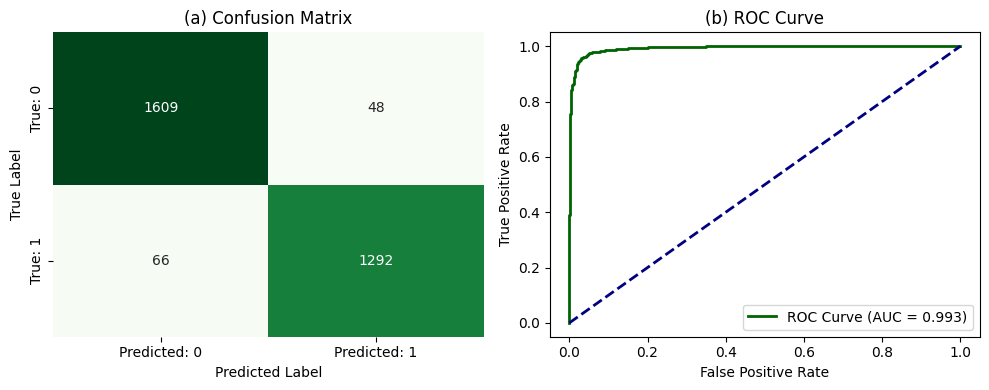

AUC Score: 0.993


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

# ------------------------------
# 📊 Confusion Matrix + ROC Curve
# ------------------------------
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 4))

# --- (a) Confusion Matrix ---
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Predicted: 0', 'Predicted: 1'],
            yticklabels=['True: 0', 'True: 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('(a) Confusion Matrix')

# --- (b) ROC Curve ---
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkgreen', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(b) ROC Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

print(f"AUC Score: {roc_auc:.3f}")


In [16]:

from scipy.signal import welch

# Assuming the 'preprocessed_data' list from our previous steps is available
# Each item in the list is a dictionary with keys 'raw', 'label', and 'subject_id'

# List to store the extracted features for all subjects
all_features = []

for item in preprocessed_data:
    raw = item['raw']
    label = item['label']
    subject_id = item['subject_id']
    
    # Get the data array from the MNE Raw object
    eeg_data = raw.get_data() # shape is (n_channels, n_times)
    
    # Calculate Power Spectral Density (PSD) using Welch's method
    sfreq = raw.info['sfreq']
    f, psd = welch(eeg_data, fs=sfreq, nperseg=int(sfreq * 2), axis=1) # 2-second segments for PSD
    
    # Define frequency bands
    bands = {
        'delta': (1, 4),
        'theta': (4, 8),
        'alpha': (8, 12),
        'beta': (12, 30),
    }

    features = {
        'subject_id': subject_id,
        'label': label
    }

    # Extract power features
    for band, (l_freq, h_freq) in bands.items():
        idx_band = np.logical_and(f >= l_freq, f <= h_freq)
        power = np.sum(psd[:, idx_band], axis=1)
        # Power is computed per channel, so we take the mean across all channels
        features[f'power_{band}'] = np.mean(power)
        
    # Extract amplitude features
    features['mean_amplitude'] = np.mean(eeg_data)
    features['median_amplitude'] = np.median(eeg_data)
    features['max_amplitude'] = np.max(eeg_data)
    features['min_amplitude'] = np.min(eeg_data)
    
    all_features.append(features)
    print(f"Extracted linear features for subject {subject_id}.")

# Create a Pandas DataFrame from the extracted features
linear_features_df = pd.DataFrame(all_features)
print("\n--- Linear Features DataFrame ---")
print(linear_features_df.head())

Extracted linear features for subject 02030007.
Extracted linear features for subject 02030003.
Extracted linear features for subject 02020010.
Extracted linear features for subject 02020025.
Extracted linear features for subject 02010008.
Extracted linear features for subject 02020026.
Extracted linear features for subject 02030004.
Extracted linear features for subject 02010022.
Extracted linear features for subject 02030014.
Extracted linear features for subject 02010025 20160311 1206.mat.mat.
Extracted linear features for subject 02010021 20150805 1730.mat.mat.
Extracted linear features for subject 02020027.
Extracted linear features for subject 02010012.
Extracted linear features for subject 02010015.
Extracted linear features for subject 02020014.
Extracted linear features for subject 02020021.
Extracted linear features for subject 02010005.
Extracted linear features for subject 02010004.
Extracted linear features for subject 02020020.
Extracted linear features for subject 020200

In [17]:
!pip install antropy

In [18]:
from antropy import spectral_entropy, svd_entropy

# Assuming the 'preprocessed_data' list from our previous steps is available
all_nonlinear_features = []

for item in preprocessed_data:
    raw = item['raw']
    subject_id = item['subject_id']
    
    eeg_data = raw.get_data() # shape is (n_channels, n_times)
    sfreq = raw.info['sfreq']

    # Initialize a dictionary for nonlinear features
    features = {
        'subject_id': subject_id,
    }

    # Extract Spectral Entropy per channel and take the mean
    spec_entropy = [spectral_entropy(eeg_data[i, :], sfreq, method='welch') for i in range(eeg_data.shape[0])]
    features['spectral_entropy'] = np.mean(spec_entropy)

    # Extract SVD Entropy per channel and take the mean
    svd_en = [svd_entropy(eeg_data[i, :]) for i in range(eeg_data.shape[0])]
    features['svd_entropy'] = np.mean(svd_en)
    
    all_nonlinear_features.append(features)
    print(f"Extracted non-linear features for subject {subject_id}.")

# Create a DataFrame for nonlinear features
nonlinear_features_df = pd.DataFrame(all_nonlinear_features)
print("\n--- Nonlinear Features DataFrame ---")
print(nonlinear_features_df.head())

Extracted non-linear features for subject 02030007.
Extracted non-linear features for subject 02030003.
Extracted non-linear features for subject 02020010.
Extracted non-linear features for subject 02020025.
Extracted non-linear features for subject 02010008.
Extracted non-linear features for subject 02020026.
Extracted non-linear features for subject 02030004.
Extracted non-linear features for subject 02010022.
Extracted non-linear features for subject 02030014.
Extracted non-linear features for subject 02010025 20160311 1206.mat.mat.
Extracted non-linear features for subject 02010021 20150805 1730.mat.mat.
Extracted non-linear features for subject 02020027.
Extracted non-linear features for subject 02010012.
Extracted non-linear features for subject 02010015.
Extracted non-linear features for subject 02020014.
Extracted non-linear features for subject 02020021.
Extracted non-linear features for subject 02010005.
Extracted non-linear features for subject 02010004.
Extracted non-linear

In [19]:
# Merge the linear and nonlinear features DataFrames
final_features_df = pd.merge(linear_features_df, nonlinear_features_df, on='subject_id')

# Re-order columns to match the paper's structure (if needed)
# The paper's tables are examples, so a direct match isn't required.
# Just ensure you have all the features in the final DataFrame.

# Print the final combined DataFrame
print("\n--- Final Features DataFrame for Model Training ---")
print(final_features_df.head())

# Save to a CSV file as per the paper
final_features_df.to_csv('eeg_features.csv', index=False)
print("\nFeatures saved to eeg_features.csv")


--- Final Features DataFrame for Model Training ---
  subject_id  label   power_delta  power_theta  power_alpha  power_beta  \
0   02030007      1    437.913438    26.045008     7.880228   10.822134   
1   02030003      1  10721.024498   229.772928    36.122350   21.437700   
2   02020010      0    580.120794    14.772517     5.500590    8.900457   
3   02020025      0   3440.397337    37.611696     7.328472   14.834356   
4   02010008      0   4512.859602    31.746571     9.299628    9.416121   

   mean_amplitude  median_amplitude  max_amplitude  min_amplitude  \
0   -2.382691e-17          0.005856    2375.638112   -1243.155849   
1   -1.045699e-17          0.162928    1559.314064   -1363.551887   
2   -6.527498e-17         -0.003320     467.445014    -360.452378   
3   -5.446879e-17         -0.079380     739.629876   -1052.964373   
4   -2.183747e-17         -0.268550     427.391445    -515.801788   

   spectral_entropy  svd_entropy  
0          2.628978     0.279423  
1          

In [20]:
final_features_df['label'].value_counts()

label
0    40
1    13
Name: count, dtype: int64

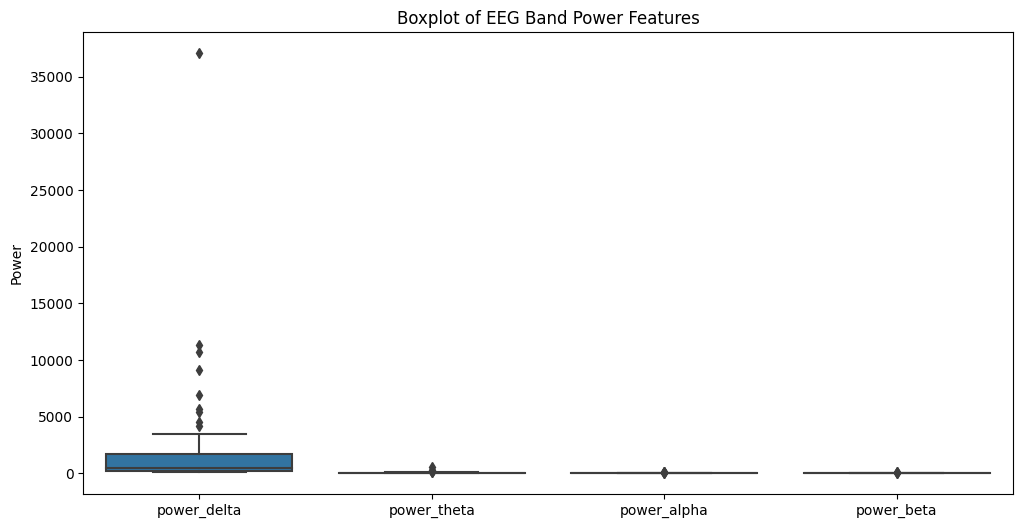

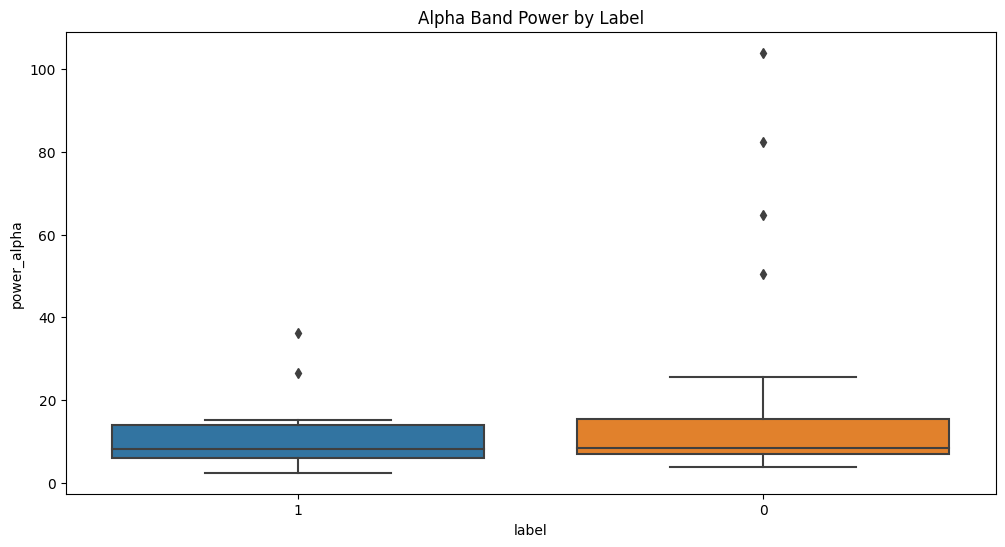

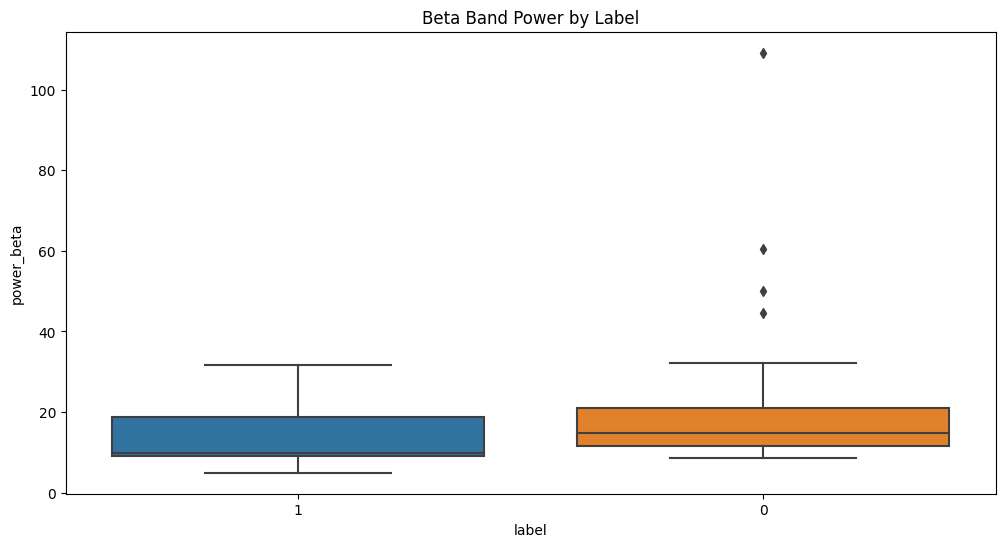

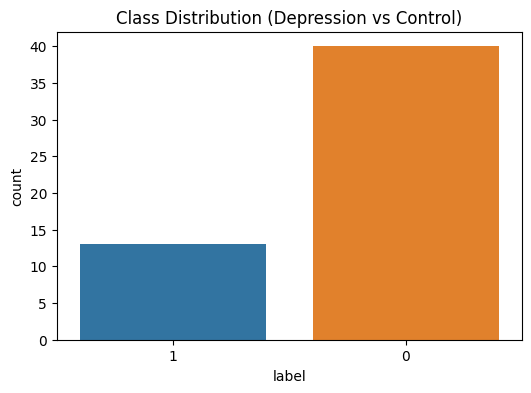

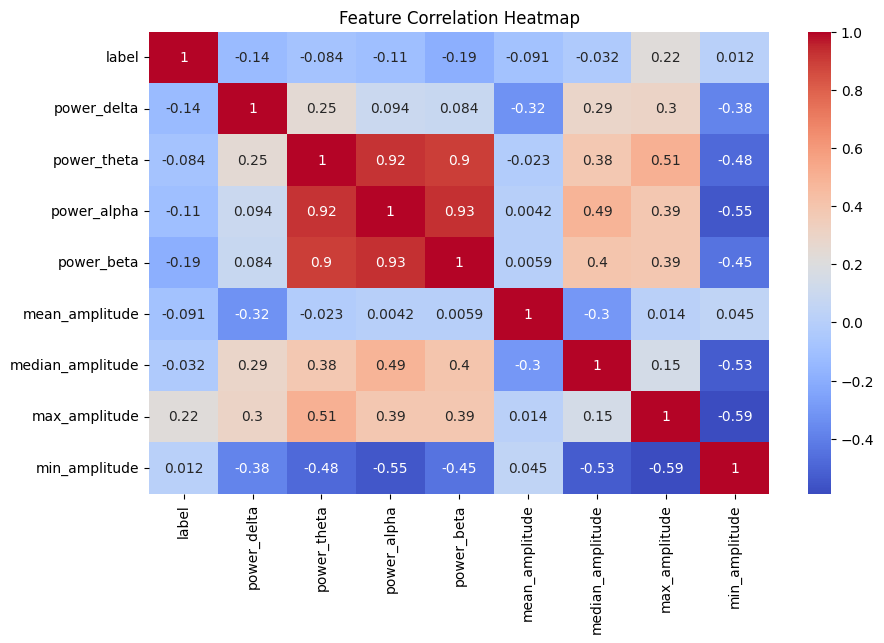

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

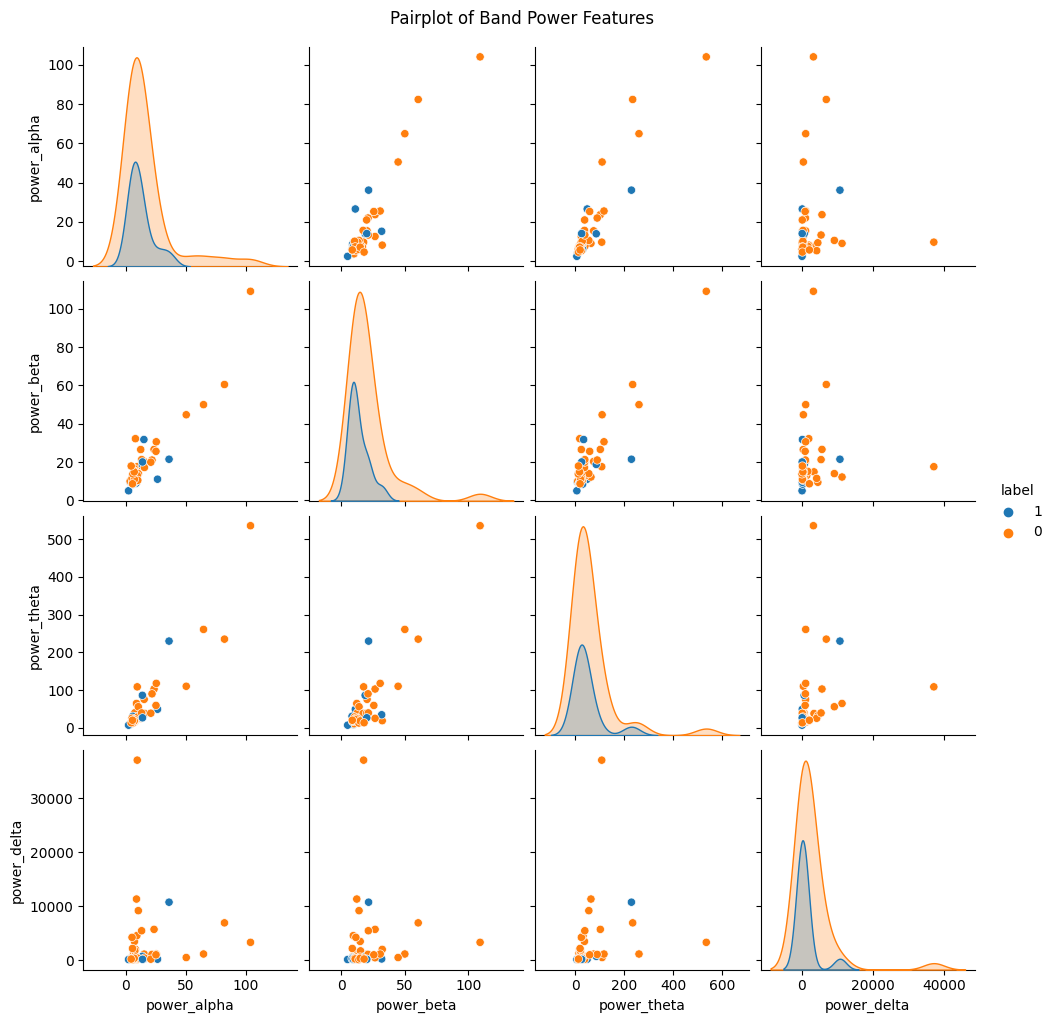

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure label is categorical
linear_features_df['label'] = linear_features_df['label'].astype(str)

# 1. Boxplots for band power
plt.figure(figsize=(12, 6))
sns.boxplot(data=linear_features_df[['power_delta', 'power_theta', 'power_alpha', 'power_beta']])
plt.title("Boxplot of EEG Band Power Features")
plt.ylabel("Power")
plt.show()

# 2. Boxplots by label (Depressed vs Control)
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='power_alpha', data=linear_features_df)
plt.title("Alpha Band Power by Label")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='power_beta', data=linear_features_df)
plt.title("Beta Band Power by Label")
plt.show()

# 3. Class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=linear_features_df)
plt.title("Class Distribution (Depression vs Control)")
plt.show()

# 4. Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(linear_features_df.drop(columns=['subject_id']).corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# 5. Pairplot for some features
sns.pairplot(linear_features_df[['power_alpha', 'power_beta', 'power_theta', 'power_delta', 'label']], hue='label')
plt.suptitle("Pairplot of Band Power Features", y=1.02)
plt.show()
